In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
url = '/content/drive/MyDrive/SoftCom/'

In [60]:
dataset_2 = url + 'Dataset_2.zip'
with ZipFile(dataset_2, 'r') as zip:
  zip.extractall()

In [61]:
PATH = '/content/'

In [62]:
data_train = pd.read_csv(PATH + 'Dataset_2/verification_train.csv')
data_test = pd.read_csv(PATH + 'Dataset_2/verification_test.csv')

In [63]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [64]:
data_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [65]:
X_data = data_train.drop("label", axis=1).values.astype(np.uint8)
y_data = data_train["label"].values

X_test = data_test.drop("label", axis=1).values.astype(np.uint8)
y_test = data_test["label"].values

In [66]:
class DigitsDataset(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = np.reshape(self.X[idx], (28, 28, 1))
        if self.transforms is not None:
            X = self.transforms(X)
        if self.y is not None:
            return X, self.y[idx]
        else:
            return X

In [67]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [68]:
train_data = DigitsDataset(X=X_data, y=y_data, transforms=transform_train)
test_data = DigitsDataset(X=X_test, y=y_test, transforms=transform_test)

# **Base Parameters**

In [69]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6


In [71]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:3000
Test dataloader:500


In [72]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [73]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [75]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 2.2992446422576904. Accuracy: 10.0
Iteration: 1000. Loss: 2.295808792114258. Accuracy: 10.0
Iteration: 1500. Loss: 2.290325403213501. Accuracy: 46.88
Iteration: 2000. Loss: 2.2075300216674805. Accuracy: 22.51
Iteration: 2500. Loss: 1.3506361246109009. Accuracy: 39.07
Iteration: 3000. Loss: 0.9506770372390747. Accuracy: 48.07
Epoch:  2
Iteration: 3500. Loss: 1.331363558769226. Accuracy: 61.78
Iteration: 4000. Loss: 1.2159589529037476. Accuracy: 61.46
Iteration: 4500. Loss: 0.6250861287117004. Accuracy: 71.45
Iteration: 5000. Loss: 0.7968798875808716. Accuracy: 72.24
Iteration: 5500. Loss: 0.9878524541854858. Accuracy: 75.3
Iteration: 6000. Loss: 0.618379533290863. Accuracy: 76.19
Epoch:  3
Iteration: 6500. Loss: 0.7943269610404968. Accuracy: 78.1
Iteration: 7000. Loss: 0.9767690896987915. Accuracy: 80.98
Iteration: 7500. Loss: 0.4191226065158844. Accuracy: 82.3
Iteration: 8000. Loss: 0.5361729860305786. Accuracy: 79.65
Iteration: 8500. Loss: 0.86086541414

[2.2992446422576904, 2.295808792114258, 2.290325403213501, 2.2075300216674805, 1.3506361246109009, 0.9506770372390747, 1.331363558769226, 1.2159589529037476, 0.6250861287117004, 0.7968798875808716, 0.9878524541854858, 0.618379533290863, 0.7943269610404968, 0.9767690896987915, 0.4191226065158844, 0.5361729860305786, 0.8608654141426086, 0.41847342252731323, 0.6354199647903442, 0.7337504625320435, 0.31284812092781067, 0.46361881494522095, 0.7491994500160217, 0.2875446379184723, 0.6277462244033813, 0.6560982465744019, 0.2899748682975769, 0.4359835088253021, 0.6708963513374329, 0.22402434051036835, 0.6074954271316528, 0.5911455154418945, 0.2463287115097046, 0.4108846187591553, 0.6010805368423462, 0.2032793015241623]


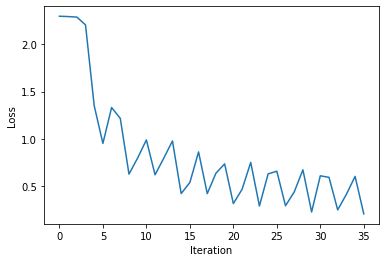

In [76]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **My Inputs**

In [79]:
batch_size = 75
num_iters = 20000
input_dim = 28*28
num_hidden = 50
output_dim = 10

learning_rate = 0.0275

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

25


In [80]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:800
Test dataloader:134


In [82]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        # self.linear_3 = nn.Linear(num_hidden, num_hidden)
        # self.relu_3 = nn.ReLU()
 
        # self.linear_4 = nn.Linear(num_hidden, num_hidden)
        # self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5= nn.ReLU()
 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        # out  = self.linear_3(out)
        # out = self.relu_3(out)
 
        # out  = self.linear_4(out)
        # out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [83]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=50, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=50, out_features=50, bias=True)
  (relu_2): ReLU()
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [85]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.4155968725681305. Accuracy: 80.17
Epoch:  2
Iteration: 1000. Loss: 0.8338892459869385. Accuracy: 80.93
Iteration: 1500. Loss: 0.6567424535751343. Accuracy: 80.5
Epoch:  3
Iteration: 2000. Loss: 0.3843129575252533. Accuracy: 82.0
Epoch:  4
Iteration: 2500. Loss: 0.4711291491985321. Accuracy: 81.68
Iteration: 3000. Loss: 0.5058453679084778. Accuracy: 80.74
Epoch:  5
Iteration: 3500. Loss: 0.6051419377326965. Accuracy: 81.66
Iteration: 4000. Loss: 0.653960645198822. Accuracy: 82.4
Epoch:  6
Iteration: 4500. Loss: 0.6113235950469971. Accuracy: 81.31
Epoch:  7
Iteration: 5000. Loss: 0.7570819854736328. Accuracy: 73.6
Iteration: 5500. Loss: 0.5954989194869995. Accuracy: 80.28
Epoch:  8
Iteration: 6000. Loss: 0.3537725806236267. Accuracy: 81.97
Epoch:  9
Iteration: 6500. Loss: 0.492636501789093. Accuracy: 82.76
Iteration: 7000. Loss: 0.5320262908935547. Accuracy: 81.93
Epoch:  10
Iteration: 7500. Loss: 0.864331841468811. Accuracy: 79.77
Iteration: 8000. Loss:

[0.4155968725681305, 0.8338892459869385, 0.6567424535751343, 0.3843129575252533, 0.4711291491985321, 0.5058453679084778, 0.6051419377326965, 0.653960645198822, 0.6113235950469971, 0.7570819854736328, 0.5954989194869995, 0.3537725806236267, 0.492636501789093, 0.5320262908935547, 0.864331841468811, 0.5414071679115295, 0.5345940589904785, 0.6531937122344971, 0.5840131640434265, 0.33788034319877625, 0.3899298906326294, 0.5872768759727478, 0.5744781494140625, 0.7496215105056763, 0.5554637908935547, 0.5674726366996765, 0.7650367021560669, 0.4794529676437378, 0.46315550804138184, 0.5391309857368469, 0.6184270977973938, 0.5469289422035217, 0.530002772808075, 0.7397432327270508, 0.5934832096099854, 0.36430442333221436, 0.3889164328575134, 0.5440110564231873, 0.6980041265487671, 0.732007622718811]


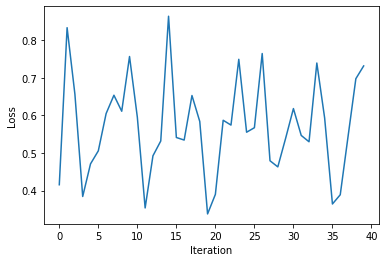

In [86]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()